In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.utils.class_weight import compute_class_weight








In [4]:
# Load data
data = pd.read_csv(r"C:\Users\USER\Downloads\breast-cancer-wisconsin-data.csv")
data = data.drop(columns="id", axis=1)

In [5]:
# Encode labels: M=1 (Malignant), B=0 (Benign)
label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])

In [6]:
data_v=data[:30]

In [7]:
# Check class distribution
print("Class distribution:")
print(data['diagnosis'].value_counts())
print("\nLabel encoding: B=0 (Benign), M=1 (Malignant)")

Class distribution:
diagnosis
0    357
1    212
Name: count, dtype: int64

Label encoding: B=0 (Benign), M=1 (Malignant)


In [8]:
# Fixed Dataset class
class BreastDataset(Dataset):
    def __init__(self, readings, diagnosis):
        # Convert to numpy arrays if they're DataFrames/Series
        self.readings = readings.values if hasattr(readings, 'values') else readings
        self.diagnosis = diagnosis.values if hasattr(diagnosis, 'values') else diagnosis
        
    def __len__(self):
        return len(self.diagnosis)
    
    def __getitem__(self, idx):
        # Return as simple feature vectors, not sequences
        readings = torch.FloatTensor(self.readings[idx])
        diagnosis = torch.LongTensor([self.diagnosis[idx]])[0]
        return readings, diagnosis

In [9]:
# Prepare data
X = data.drop(columns=['diagnosis'], axis=1)
y = data['diagnosis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create datasets and dataloaders
train_dataset = BreastDataset(X_train, y_train)
test_dataset = BreastDataset(X_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [10]:
# Model definition
class BreastClassif(nn.Module):
    def __init__(self, input_size, hidden_size, out_dim, dropout=0.4):
        super(BreastClassif, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size, out_dim)
        )
    
    def forward(self, x):
        out = self.model(x)
        return out

# Model parameters
input_size = 30
hidden_size = 124
out_dim = 2
dropout = 0.4

# Compute class weights for imbalanced data
classes = np.unique(y_train)
class_weight = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = torch.tensor(class_weight, dtype=torch.float32)
print(f"\nClass weights: {class_weight}")

# Initialize model
model = BreastClassif(input_size, hidden_size, out_dim, dropout)
criterion = nn.CrossEntropyLoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=0.01)



Class weights: tensor([0.7982, 1.3382])


In [11]:
# Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=100):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        if (epoch + 1) % 10 == 0:  # Print every 10 epochs
            print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return train_losses, val_losses, train_accs, val_accs


In [12]:

def evaluate_model(model, test_loader):
    """Evaluate model on test set"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.numpy())
            all_labels.extend(y_batch.numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'\nTest Accuracy: {accuracy*100:.2f}%')
    
    # Classification report
    class_names = ['Benign', 'Malignant']
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print('\nConfusion Matrix:')
    print(cm)
    print('\n[TN  FP]')
    print('[FN  TP]')
    
    return accuracy, all_preds, all_labels

# Train the model
print("\nStarting training...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, test_loader, optimizer, criterion, epochs=100
)

# Evaluate the model
print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)
accuracy, preds, labels = evaluate_model(model, test_loader)

# Save the model
torch.save(model.state_dict(), 'breast_cancer_model.pth')



Starting training...
Epoch 10: Train Loss: 0.3808, Train Acc: 80.00%, Val Loss: 0.2668, Val Acc: 92.11%
Epoch 20: Train Loss: 0.2361, Train Acc: 88.79%, Val Loss: 0.3937, Val Acc: 88.60%
Epoch 30: Train Loss: 0.2400, Train Acc: 90.55%, Val Loss: 0.2544, Val Acc: 90.35%
Epoch 40: Train Loss: 0.2195, Train Acc: 90.33%, Val Loss: 0.2245, Val Acc: 92.11%
Epoch 50: Train Loss: 0.2394, Train Acc: 89.45%, Val Loss: 0.2040, Val Acc: 92.98%
Epoch 60: Train Loss: 0.2301, Train Acc: 89.67%, Val Loss: 0.2442, Val Acc: 90.35%
Epoch 70: Train Loss: 0.2561, Train Acc: 91.43%, Val Loss: 0.2689, Val Acc: 91.23%
Epoch 80: Train Loss: 0.2217, Train Acc: 92.09%, Val Loss: 0.2143, Val Acc: 92.11%
Epoch 90: Train Loss: 0.2227, Train Acc: 89.45%, Val Loss: 0.2395, Val Acc: 91.23%
Epoch 100: Train Loss: 0.2085, Train Acc: 91.65%, Val Loss: 0.1806, Val Acc: 93.86%

FINAL EVALUATION ON TEST SET

Test Accuracy: 93.86%

Classification Report:
              precision    recall  f1-score   support

      Benign   

In [13]:
data_v

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.71190,0.26540,0.4601,0.11890
1,1,20.570,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.24160,0.18600,0.2750,0.08902
2,1,19.690,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.45040,0.24300,0.3613,0.08758
3,1,11.420,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.68690,0.25750,0.6638,0.17300
4,1,20.290,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.40000,0.16250,0.2364,0.07678
5,1,12.450,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.53550,0.17410,0.3985,0.12440
6,1,18.250,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.37840,0.19320,0.3063,0.08368
7,1,13.710,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.26780,0.15560,0.3196,0.11510
8,1,13.000,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.53900,0.20600,0.4378,0.10720
9,1,12.460,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.10500,0.22100,0.4366,0.20750


In [14]:
data_v_y=data_v.iloc[:,:1]


In [15]:
data_v_y

,diagnosis
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [16]:
data_v=data_v.iloc[:,-30:]
data_v.head(2)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [17]:
#using random forest to get feature importance
from sklearn.ensemble import RandomForestClassifier


In [18]:
rf=RandomForestClassifier(criterion='gini',max_depth=20,max_features='sqrt',min_samples_split=2,class_weight='balanced')

In [19]:
new_data=data[30:]

In [20]:
new_data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
30,1,18.63,25.11,124.80,1088.0,0.10640,0.18870,0.23190,0.12440,0.2183,...,23.150,34.01,160.50,1670.0,0.14910,0.42570,0.6133,0.1848,0.3444,0.09782
31,1,11.84,18.70,77.93,440.6,0.11090,0.15160,0.12180,0.05182,0.2301,...,16.820,28.12,119.40,888.7,0.16370,0.57750,0.6956,0.1546,0.4761,0.14020
32,1,17.02,23.98,112.80,899.3,0.11970,0.14960,0.24170,0.12030,0.2248,...,20.880,32.09,136.10,1344.0,0.16340,0.35590,0.5588,0.1847,0.3530,0.08482
33,1,19.27,26.47,127.90,1162.0,0.09401,0.17190,0.16570,0.07593,0.1853,...,24.150,30.90,161.40,1813.0,0.15090,0.65900,0.6091,0.1785,0.3672,0.11230
34,1,16.13,17.88,107.00,807.2,0.10400,0.15590,0.13540,0.07752,0.1998,...,20.210,27.26,132.70,1261.0,0.14460,0.58040,0.5274,0.1864,0.4270,0.12330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [21]:
le=LabelEncoder()

In [22]:
new_data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [23]:
new_data['diagnosis']=le.fit_transform(new_data['diagnosis'])

C:\Users\USER\AppData\Local\Temp\ipykernel_7828\1373231965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['diagnosis']=le.fit_transform(new_data['diagnosis'])


In [24]:
new_data.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
30,1,18.63,25.11,124.80,1088.0,0.1064,0.1887,0.2319,0.12440,0.2183,...,23.15,34.01,160.5,1670.0,0.1491,0.4257,0.6133,0.1848,0.3444,0.09782
31,1,11.84,18.70,77.93,440.6,0.1109,0.1516,0.1218,0.05182,0.2301,...,16.82,28.12,119.4,888.7,0.1637,0.5775,0.6956,0.1546,0.4761,0.14020


In [25]:
X=new_data.drop(columns=['diagnosis'],axis=1)
y=new_data['diagnosis']

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [27]:
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20)

In [28]:
rf.score(X_train,y_train)

1.0

In [29]:
pred=rf.predict(X_test)

In [30]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        72
           1       0.90      0.97      0.93        36

    accuracy                           0.95       108
   macro avg       0.94      0.96      0.95       108
weighted avg       0.96      0.95      0.95       108



In [31]:
val_pred=rf.predict(data_v)

In [32]:
print(classification_report(val_pred,data_v_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        27

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [33]:
importance=rf.feature_importances_

In [34]:
features=X_train.columns

In [35]:
importance_df=pd.DataFrame({"Feature":features,"importances":importance})

In [36]:
importance_df

,Feature,importances
0,radius_mean,0.022127
1,texture_mean,0.016807
2,perimeter_mean,0.037279
3,area_mean,0.034037
4,smoothness_mean,0.005878
5,compactness_mean,0.014343
6,concavity_mean,0.043709
7,concave points_mean,0.100295
8,symmetry_mean,0.003016
9,fractal_dimension_mean,0.002658


In [37]:
imp_df=importance_df.sort_values(by="importances",ascending=False)

print(imp_df)

                    Feature  importances
22          perimeter_worst     0.146959
23               area_worst     0.135034
27     concave points_worst     0.121240
7       concave points_mean     0.100295
20             radius_worst     0.093634
26          concavity_worst     0.046879
6            concavity_mean     0.043709
13                  area_se     0.038388
2            perimeter_mean     0.037279
3                 area_mean     0.034037
10                radius_se     0.026706
0               radius_mean     0.022127
21            texture_worst     0.019448
12             perimeter_se     0.018956
1              texture_mean     0.016807
25        compactness_worst     0.016623
24         smoothness_worst     0.014620
5          compactness_mean     0.014343
28           symmetry_worst     0.006910
29  fractal_dimension_worst     0.006794
4           smoothness_mean     0.005878
16             concavity_se     0.005432
14            smoothness_se     0.005245
11              

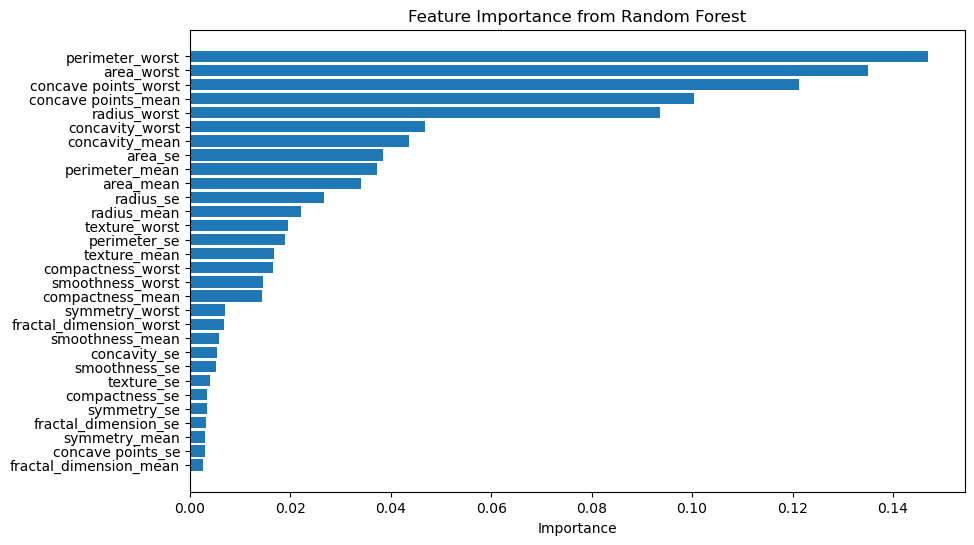

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(imp_df['Feature'], imp_df['importances'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()


In [39]:
#pip install mlflow

In [40]:
import wandb

In [41]:
wandb.init(project="breast classification",config={"criterion": "gini",
        "max_depth": 20,
        "max_features": "sqrt",
        "min_samples_split": 2,
        "class_weight": "balanced",
        "model": "RandomForest"})

wandb: Currently logged in as: adey004azeez (adey004azeez-hiipower-academy) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [42]:
# Make predictions
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Accuracy: 1.0000
Test Accuracy: 0.9537


In [43]:
# Log metrics to wandb
wandb.log({
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy})

In [46]:
# Log confusion matrix
wandb.log({
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=np.array(y_test),
        preds=np.array(test_pred),
        class_names=["Benign", "Malignant"])
})


In [48]:
# Log feature importance as table
wandb.log({"feature_importance": wandb.Table(dataframe=imp_df)})


In [49]:
import joblib

In [50]:
# Save model locally
model_filename = 'random_forest_breast_cancer.pkl'
joblib.dump(rf, model_filename)



['random_forest_breast_cancer.pkl']

In [51]:

# Save model to wandb
artifact = wandb.Artifact(
    name='breast-cancer-rf-model',
    type='model',
    description='Random Forest model for breast cancer classification',
    metadata={
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'n_features': X.shape[1],
        'n_samples': len(X)
    }
)
artifact.add_file(model_filename)
wandb.log_artifact(artifact)

<Artifact breast-cancer-rf-model>

In [52]:
wandb.finish()

test_accuracy,▁
train_accuracy,▁
test_accuracy,0.9537
train_accuracy,1
